# Time Series Analysis: Zillow Home Values in Chicago

Project 4

Flatiron School

by Carly Tsuda

May 2021

## Business Question

The controversial Tax Increment Financing program in the city of Chicago is undergoing an overhaul under newly-elected Chicago Mayor Lori Lightfoot. Lightfoot hopes to improve transparency and equity in the program and who it benefits. As part of this plan, she has established a Community Stakeholder team to oversee decisions about what districts are added to the program and which projects receive funding. 

The first step this group has taken is to analyze the current status of housing prices in this city, and to forecast what they can expect for the future. The group wants a sense of how much risk they can take when making decisions using TIF funding, particularly regarding plans that intend to operate on bond. 

## Data Understanding

In [76]:
import numpy as np
import pandas as pd

#for importing lat/long
import geopy
from geopy.geocoders import Nominatim

#for visualizations
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

#time-series specific 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# for feature selection in ARIMA
import warnings
warnings.filterwarnings('ignore')
import itertools

# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

I'm using Zillow home value data from 1996 - 2018. The data represents aggregated home value for each zip code in the US, and also includes the city, county, larger metro area, and state for each zip code. It also includes a variable 'SizeRank'. This dataset was included as project data in the assignment, and might not be the most recent data available. 

I initially filtered for Chicago by the 'City' column of the dataset. When this yielded fewer zip codes than expected, I chose filter by metro area instead, and use another method for extracting zip codes from the Chicago city proper.

In [16]:
#load in data
df = pd.read_csv("data/zillow_data.csv")
#separate for only chicago data
chicago = df.loc[df['City'] == 'Chicago']
print('Total zip codes: {}'.format(chicago['RegionName'].nunique()))

df = df.loc[df['Metro'] == 'Chicago']

Total zip codes: 41


### Preprocessing

I want to change the data type of the column headers so that when I melt the data into a series, the data type is a Datetime Index. 

In [17]:
def get_datetimes(df, startcol):
    '''This function converts all of the headers for time series columns into Datetime format. 
    Accepts a dataframe and the index of the first time column'''
    
    return pd.to_datetime(df.columns.values[startcol:], format='%Y-%m')

#apply to the dataframe
get_datetimes(df, 7)


DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

Feature engineering some lat/long baybee

Doing it up here so that I can drop or fill rows later without calling the geolocator again

In [18]:
#setting to an open-source geolocator
geolocator = Nominatim(user_agent='project_4_time_series')

def get_lat(geolocator, locstring):
    '''Returns the latitude of the given string, expects a zipcode.'''
    location = geolocator.geocode('US ' + locstring) #specifying US is necessary to avoid getting French zip codes
    return location.latitude

def get_lon(geolocator, locstring):
    '''Returns the longitude of the given string, expects a zipcode.'''
    location = geolocator.geocode('US ' + locstring)
    return location.longitude

pull_data = 0

if (pull_data):
    #create new latitude and longitude columns
    df['latitude'] = df.apply(lambda x: get_lat(geolocator, str(x['RegionName'])), axis = 1)
    df['longitude'] = df.apply(lambda x: get_lon(geolocator, str(x['RegionName'])), axis = 1)

    #save a local copy of the new dataframe to avoid running the calls to the geolocator every time
    df.to_csv('geocoded_data.csv')
else:
    df = pd.read_csv('geocoded_data.csv', index_col = 0)

dealing with null values

In [19]:
#show which rows have missing values, and how many
missing_count = df.shape[1] - df.count(axis=1)
print('Missing values for each row:')
print(missing_count)

#save indeces of rows with some missing values, just in case
missing = missing_count[df.isna().any(axis=1)]
missing_indices = list(missing.index)
print('Number rows with missing values: {}'.format(len(missing_indices)))

Missing values for each row:
0          0
3          0
7          0
16         0
19         0
        ... 
14257      0
14275      0
14316      0
14499    189
14604      0
Length: 325, dtype: int64
Number rows with missing values: 8


For now, I want to have two drop approaches for the data. I want to try running the data where I've simply dropped rows with null values, and also I want to try using data that's been back-filled. 

The larger dataset has less missing data overall, where it's concentrated in only 8 zip codes overall. It might be okay for this dataset to drop the rows that are missing lots of data. 
The neighborhood dataset has more missing data, so the filled dataset might be more useful. 

In [20]:
#separate out columns with not time-data 
start = df.iloc[:, :7]
middle = df.iloc[:, 272:]

#get time data, fill in the NaNs
time_data = df.iloc[:, 7:272]
#I first used ffill to fill NaNs with the most recent data. 
#Then I went back and did a second pass of bfill to address the first Nan
time_data = time_data.ffill(axis=1).bfill(axis=1)

#put it all back together
df = pd.concat([start, middle, time_data], axis=1)

#check for any more NaNs
# df.info(varbose=True, null_counts=True)

I wanted to break down all of the zip codes to smaller sub-sections. I created lists of the zip codes in each of the TIF community development zones, and mapped those to the zip code columns. 

I then dropped all of the columns that didn't get mapped to try to capture more of the zip codes than sorting by the City column. I captured the same number with both methods.

In [21]:
#hand input from Chicago area map
north = [60626, 60645, 60660, 60640, 60613, 60657, 60614]
northwest = [60631, 60646, 60630, 60641, 60634, 60656, 60659, 60625, 60618, 60647, 60639, 60707, 60651, 60622, 60642]
central = [60610, 60611, 60661, 60606, 60601, 60602, 60603, 60604, 60605]
west = [60644, 60624, 60612, 60607, 60608, 60623]
southwest = [60632, 60638, 60629, 60609]
south = [60616, 60653, 60615, 60637, 60619, 60636, 60621, 60620]
far_south = [60649, 60617, 60633, 60627, 60628, 60643, 60655, 60652]

#map regions based on zip codes to integer region code
mp = {k: lbl
     for lst, lbl in [(north, 0), (northwest, 1), (central, 2), (west, 3), (southwest, 4), (south, 5), (far_south, 6)]
     for k in lst}
df['RegionCode'] = df['RegionName'].map(mp)

#drop rows that don't get mapped 
#new strategies for selecting zip codes
#(didn't work)
df = df.dropna()

#key of region string names, indices correspond to region codes
region_key = ['North', 'Northwest', 'Central', 'West', 'Southwest', 'South', 'Far South']

#check
#df.info(verbose=True, null_counts=True)

With all of my columns added, it's time to melt! I used the adapted function that we created as a class to create a 'long-format' dataframe, with multiple rows per zip code, each representing a single month.

In [22]:
def melt_data(df, vars_list):
    '''Transforms df from one row per zip code to many rows for each zip code each representing a time measurement
    Accepts a dataframe and a list of string names of not-time columns to transform'''
    melted = pd.melt(df, 
                     id_vars=vars_list, 
                     var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

vars_list = ['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank', 'latitude', 'longitude', "RegionCode"]
melt = melt_data(df, vars_list)

#cheque

print('Melt Check')
print("Before: {} , After: {}".format(df.shape, melt.shape))

Melt Check
Before: (41, 275) , After: (10865, 12)


### EDA and Visualization

I first printed out some summary statistics to get a better sense of each of the columns overall

In [28]:
for col in vars_list:
    print("Column details: " + col)
    print(df[col].describe());

Column details: RegionID
count        41.000000
mean      92318.756098
std       49207.091298
min       84607.000000
25%       84620.000000
50%       84634.000000
75%       84647.000000
max      399713.000000
Name: RegionID, dtype: float64
Column details: RegionName
count       41.000000
mean     60634.390244
std         20.226070
min      60605.000000
25%      60618.000000
50%      60633.000000
75%      60647.000000
max      60707.000000
Name: RegionName, dtype: float64
Column details: City
count          41
unique          2
top       Chicago
freq           40
Name: City, dtype: object
Column details: State
count     41
unique     1
top       IL
freq      41
Name: State, dtype: object
Column details: Metro
count          41
unique          1
top       Chicago
freq           41
Name: Metro, dtype: object
Column details: CountyName
count       41
unique       1
top       Cook
freq        41
Name: CountyName, dtype: object
Column details: SizeRank
count      41.000000
mean     1258.0243

I made a few helper functions to make managing the dataset easier:
* isolate_zip will extract the time data for a single zip code and melt it into a time series
* isolate_region will aggregate the data for a given region, and melt it into a time series
* plot_rolling will plot the time series, rolling mean, and rolling standard deviation for a given time series

In [31]:
def isolate_zip(data, zip_code):
    '''returns a time series of only the specified zip code
    accepts a wide form dataframe and the zip code'''
    
    #pull out the row of the specific zip code
    section = data.loc[data['RegionName'] == zip_code]
    
    #melt data into long form
    section = melt_data(section, vars_list)
    
    #ensure that the index is in datetime format
    x = pd.DatetimeIndex(section['time'], freq='infer')
    
    #assemble and return time series
    return pd.Series(section['value'].to_numpy(), 
                         index=x)
#check
#isolate_zip(df, 60640)

In [32]:
def isolate_subregion(data, subregion_id):
    '''returns a time series of only the given region
    accepts a wide form dataframe and the region code'''
    
    #isolate by region and aggregate data
    subregion = data.groupby(by=['RegionCode']).mean()
    subregion = subregion.iloc[[subregion_id]]
    
    #melt into long form
    subregion_vars = ['RegionID', 'RegionName', 'SizeRank', 'latitude', 'longitude']
    #subregion_vars = []
    subregion = melt_data(subregion, subregion_vars)
    
    #ensure that the index is in datetime format
    x = pd.DatetimeIndex(subregion['time'], freq='infer')
    
    #assemble and return time series
    return pd.Series(subregion['value'].to_numpy(), 
                         index=x)

#check
#isolate_subregion(df, 0)

In [33]:
def plot_rolling(series, titlestring):
    #stationary
    y = series.values

    x = series.index

    roll_mean = series.rolling(window=8, center=False).mean()
    roll_std = series.rolling(window=8, center=False).std()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y, line=go.scatter.Line(color='blue'), name='Original'))
    fig.add_trace(go.Scatter(x=x, y=roll_mean, line=go.scatter.Line(color='red'), name='Rolling Mean'))
    fig.add_trace(go.Scatter(x=x, y=roll_std, line=go.scatter.Line(color='black'), name='Rolling Std'))

    title = titlestring + " Rolling Mean and Standard Deviation"

    #title
    fig.update_layout(title_text=title)

    # Set x-axis title
    fig.update_xaxes(title_text="Year")

    # Set y-axes titles
    fig.update_yaxes(title_text="Aggregate Housing Cost")
    fig.show()

#check
#plot_rolling(isolate_zip(df, 60640), '60640')

I wanted to compare the original time series for each region.
Some notable trends:
* over time the stratification of the indicated regions becomes more dramatic
* the most dramatic growth has been in the North region
* the only two regions to recover from the 2008 housing bubble are North and Central
* other regions were only just recovering as of 2018, if at all

In [34]:
fig = go.Figure()

#iterate through each subregion
for i in range(0,7):
    ser = isolate_subregion(df, i)
    y = ser.values
    x = ser.index
    fig.add_trace(go.Scatter(x=x, y=y, name=region_key[i]))
#title
fig.update_layout(title_text='Chicago Housing Trends by Region')

# Set x-axis title
fig.update_xaxes(title_text="Year")

# Set y-axes titles
fig.update_yaxes(title_text="Aggregate Housing Cost")
fig.show()

I had visions of many beautiful choropleth maps! I first tried to make one mapping the regions to double-check visually how they had been coded.

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/smartchicago/chicago-atlas/master/db/import/zipcodes.geojson') as response:
    zip_codes = json.load(response)
    
fig = px.choropleth_mapbox(df, geojson=zip_codes, locations='RegionName', color='RegionCode',
                           color_continuous_scale="Viridis",
                           featureidkey='properties.ZIP',
                           #range_color=(50000,700000),
                           mapbox_style="carto-positron",
                           zoom=9, center = {"lat": 41.8781, "lon": -87.6298},
                           opacity=0.5,
                           labels={'1996-04':'Home Values, April 1996'}
                          )
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Running a value count showed that, not only were there missing zip codes, but that some of the zip codes weren't showing up on the choropleth map (likely due to missing geojson). I abandoned my choropleth ambitions.

In [ ]:
df['RegionCode'].value_counts()

My next step was to check the aspects of the time series data. I was specifically looking to understand the following three characteristics for each region: 
* stationarity 
* seasonality
* autocorrelation

At this point it's pretty evident that my series are very not stationary, but I went ahead and plotted the rolling mean and rolling standard deviation to get a better sense of any underlying patterns.

In [36]:
#plot the rolling mean/std dev graph for each subregion

for subregion in range(0,7):
    plot_rolling(isolate_subregion(df, subregion), region_key[subregion])


Next, I wanted to see if there were any seasonal patterns that I wasn't picking up with the full 12-year plots. Since most of the single-year plots were straight lines with differing slopes, I didn't think that seasonality was playing a big part of the data for the most part.

In [37]:
# check for seasonality
for i in range(0, 7):
    fig = go.Figure()
    for year in range(1996, 2019):
        ser = isolate_subregion(df, i).loc[str(year)]

        y = ser.values
        x = ser.index.month
        fig.add_trace(go.Scatter(x=x, y=y, name=str(year)))
    #title
    fig.update_layout(title_text= region_key[i] + ' Housing Trends by Year')

    # Set x-axis title
    fig.update_xaxes(title_text="Month")

    # Set y-axes titles
    fig.update_yaxes(title_text= "Aggregate Home Price in USD")
    fig.show()


To see if there was autocorrelation, I plotted the autocorrelation for each subregion. Seeing the autocorrelation start out strong and then hover around 0 was ideal. I would have liked to see less dramatic peaks/troughs in the data, but 

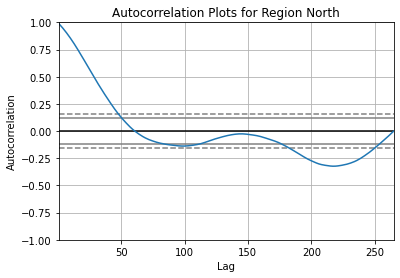

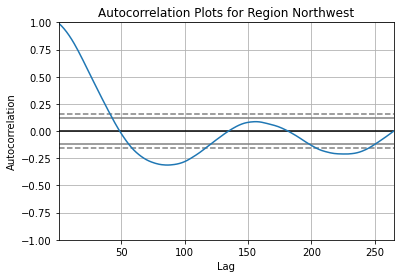

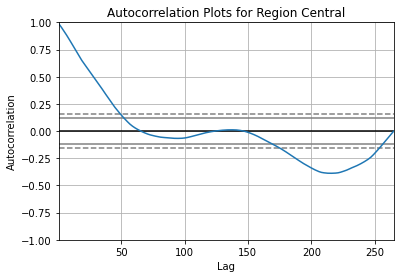

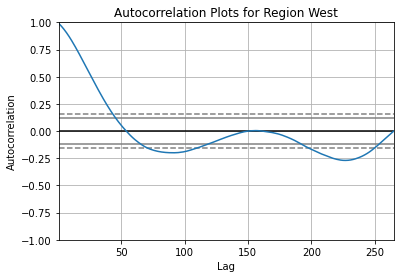

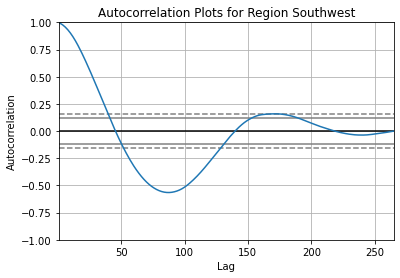

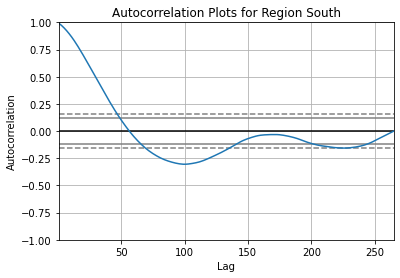

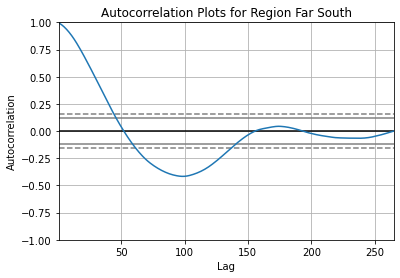

In [45]:
#check autocorrelation plots for each region
for i in range(0,7):
    fig = plt.figure()
    fig = pd.plotting.autocorrelation_plot(isolate_subregion(df, i))
    plt.title('Autocorrelation Plots for Region ' + region_key[i])

## Processing

Here I did my test-train split. The goal was to identify the date at the 80% mark of the dataset, then keep that value as a marker for splitting the data in the future. I also made wide form dataframes for use in my helper functions

In [46]:
temp = isolate_zip(df, 60640)

SPLIT = int(temp.shape[0]*0.8)
train, test = temp[:SPLIT], temp[SPLIT:]

#check
print(train.shape, test.shape)

#train

#create wide-form dataframes split into test and train (for use in the helper fuctions I created previously)
train = pd.concat([df.iloc[:, 0:9], df.iloc[:, 274], df.iloc[:,9:210]], axis=1)
test = pd.concat([df.iloc[:, 0:9], df.iloc[:, 274], df.iloc[:,210:274]], axis=1)

(212,) (53,)


After creating my first model with a single zip code, I wanted to try aggregating the data to city-wide to see if doing so would smooth out some of the noise in the dataset

In [48]:
city_model = melt.groupby(by='time').mean()
city_model = city_model['value']


city_train = melt_data(train, vars_list).groupby(by='time').mean()
city_train = city_train['value']
city_test = melt_data(test, vars_list).groupby(by='time').mean()
city_test = city_test['value']


Also after my first few models in ARIMA, I suspected that just looking at the data in visualizations was probably a bad way to pick up seasonality. I went ahead and decomposed my aggregated data to isolate just the trend, and build my model on that.

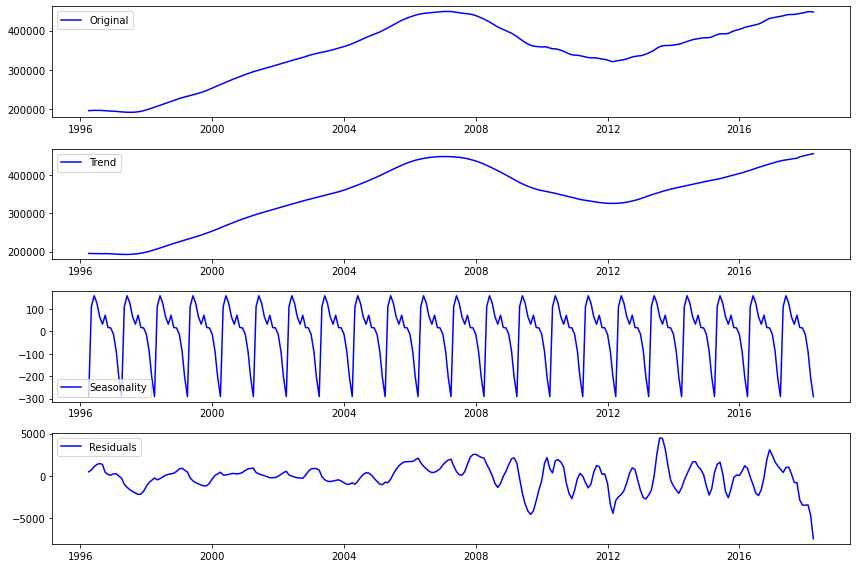

In [49]:
decomposition = seasonal_decompose(city_model, model = 'additive', extrapolate_trend = 'freq')
# Gather the trend, seasonality, and residuals 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(city_model, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

## Modeling

### ARIMA

I first started modeling with a single zip code to better understand the process.

In [53]:
#model ARIMA with one zip
arima_model = ARIMA(isolate_zip(train, 60640), order=(1, 1, 1)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  201
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1933.858
Date:                Tue, 18 May 2021   AIC                           3873.717
Time:                        12:05:09   BIC                           3883.612
Sample:                    04-01-1996   HQIC                          3877.721
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9813      0.007    144.929      0.000       0.968       0.995
ma.L1         -0.9599      0.010    -98.205      0.000      -0.979      -0.941
sigma2       1.45e+07    8.9e-12   1.63e+18      0.000    1.45e+07    1.45e+07
===================================================================================
Ljung-Box (L1) (Q):                 152.98   Jarque-Bera (JB):                 0.84
Prob(Q):                              0.00   Prob(JB):                         0.66
Heteroskedasticity (H):               2.90   Skew:                            -0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.43e+34. Standard errors may be unstable.
"""

After the initial model, the next step was to run a grid-search like map of the different value options for p, d, and q to determine which combination optimized the AIC value

In [55]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

ans = []
for comb in pdq:
    try:
        mod = ARIMA(isolate_zip(train, 60640),
                    order=comb,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
    except ValueError:
        pass

ARIMA (0, 0, 0) : AIC Calculated =6240.9239627972065
ARIMA (0, 0, 1) : AIC Calculated =5204.661587481161
ARIMA (0, 0, 2) : AIC Calculated =5136.894152591008
ARIMA (0, 1, 0) : AIC Calculated =3938.0242229892747
ARIMA (0, 1, 1) : AIC Calculated =3738.50354669217
ARIMA (0, 1, 2) : AIC Calculated =3478.364547073037
ARIMA (0, 2, 0) : AIC Calculated =3551.235147314318
ARIMA (0, 2, 1) : AIC Calculated =3489.9754652668084
ARIMA (0, 2, 2) : AIC Calculated =3440.156986296418
ARIMA (1, 0, 0) : AIC Calculated =3944.0522655568666
ARIMA (1, 0, 1) : AIC Calculated =3749.9504097409836
ARIMA (1, 0, 2) : AIC Calculated =3488.722575343717
ARIMA (1, 1, 0) : AIC Calculated =3562.645973601345
ARIMA (1, 1, 1) : AIC Calculated =3513.0549920522103
ARIMA (1, 1, 2) : AIC Calculated =3440.9293642205234
ARIMA (1, 2, 0) : AIC Calculated =3521.9021216593474
ARIMA (1, 2, 1) : AIC Calculated =3487.0029854935747
ARIMA (1, 2, 2) : AIC Calculated =3438.4712377376018
ARIMA (2, 0, 0) : AIC Calculated =3563.2130097076465
AR

I then ran ARIMA again with the optimized parameters to see the results. I wasn't thrilled about the high p-values in the moving average section.

In [56]:
output = ARIMA(isolate_zip(train, 60640), order=(2, 2, 2),
              enforce_stationarity=False,
              enforce_invertibility=False).fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  201
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1691.606
Date:                Tue, 18 May 2021   AIC                           3393.211
Time:                        12:07:47   BIC                           3409.602
Sample:                    04-01-1996   HQIC                          3399.847
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5880      0.056     10.518      0.000       0.478       0.698
ar.L2         -0.6419      0.048    -13.413      0.000      -0.736      -0.548
ma.L1          0.0618      0.074      0.838      0.402      -0.083       0.206
ma.L2          0.0047      0.073      0.065      0.948      -0.138       0.147
sigma2      1.882e+06   1.03e+05     18.281      0.000    1.68e+06    2.08e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               538.61
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              82.51   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

I plotted the diagnostics for this model. I didn't love the distribution of the residuals: I would have preferred to see more heteroskedasticity, but seeing greater residuals on one side of the plot indicated that the model was having a difficult time reconciling the patterns it was seeing.

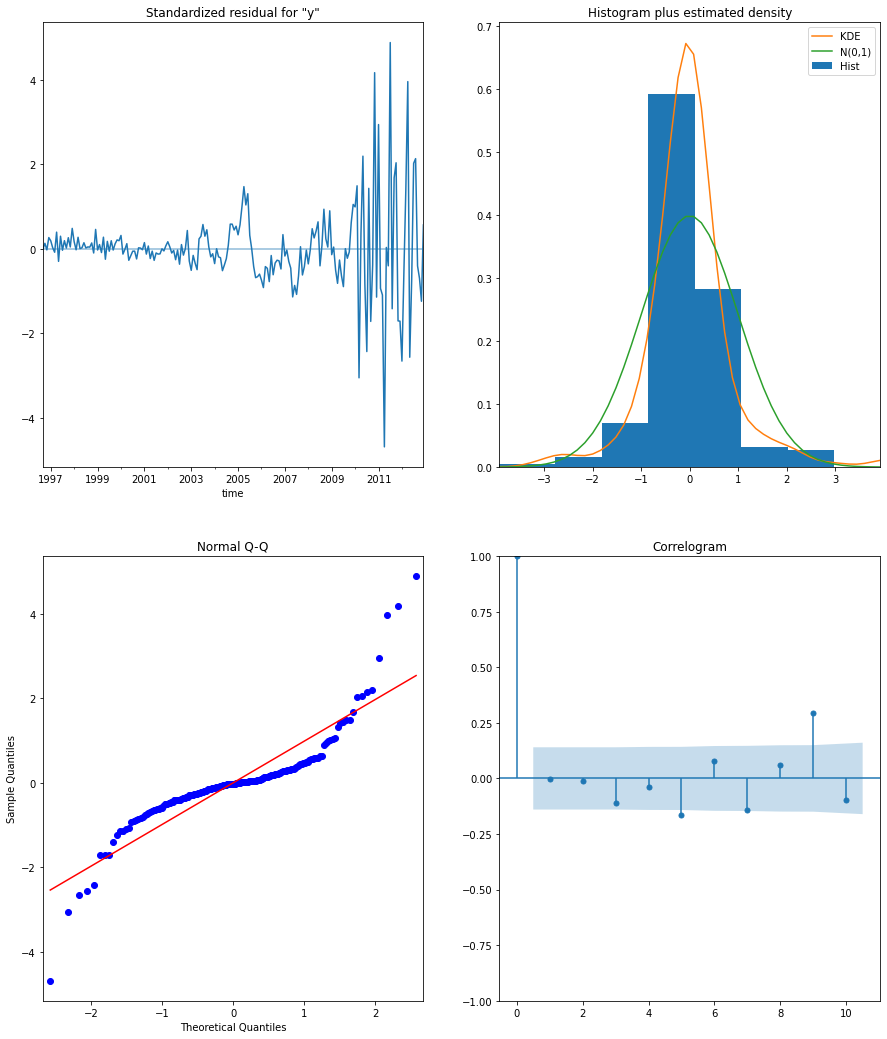

In [58]:
output.plot_diagnostics(figsize=(15,18))
plt.show()

I then plotted the prediction against my test data, which was not great. The model didn't even get the value of the slope right.

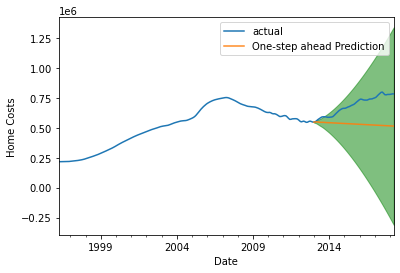

In [60]:
#calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-01-01'), end= pd.to_datetime('2018-04-01'), dynamic=False)
pred_conf = pred.conf_int()
ax = isolate_zip(df, 60640).plot(label='actual')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Prediction', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Costs')
plt.legend()

plt.show()

I then checked the Mean Squared Error, which was, predictably, large.

In [61]:
# Get the real and predicted values
forecasted = pred.predicted_mean
actual = isolate_zip(test, 60640)

# Compute the mean square error
mse = ((forecasted - actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 31505877767.55


I was curious if the model was confused about the reversal in trends around 2008. I reframed the data to include fewer reversals in slope, and created a new model with that data.

In [63]:
temp = isolate_zip(df, 60640)['2009-01-01':]

SPLIT = int(temp.shape[0]*0.8)
train, test = temp[:SPLIT], temp[SPLIT:]

#check
train.shape, test.shape

#train

#test train split
train = pd.concat([df.iloc[:, 0:9], df.iloc[:, 274], df.iloc[:,160:249]], axis=1)
test = pd.concat([df.iloc[:, 0:9], df.iloc[:, 274], df.iloc[:,249:272]], axis=1)

In [64]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

ans = []
for comb in pdq:
    try:
        mod = ARIMA(isolate_zip(train, 60640),
                    order=comb,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
    except ValueError:
        pass

ARIMA (0, 0, 0) : AIC Calculated =2471.3323832876627
ARIMA (0, 0, 1) : AIC Calculated =2076.389224806925
ARIMA (0, 0, 2) : AIC Calculated =2035.0482544620218
ARIMA (0, 1, 0) : AIC Calculated =1747.1404713291458
ARIMA (0, 1, 1) : AIC Calculated =1647.7031864195399
ARIMA (0, 1, 2) : AIC Calculated =1580.1695501974025
ARIMA (0, 2, 0) : AIC Calculated =1639.118297801141
ARIMA (0, 2, 1) : AIC Calculated =1611.8677241141086
ARIMA (0, 2, 2) : AIC Calculated =1581.6539543660642
ARIMA (1, 0, 0) : AIC Calculated =1767.65160985077
ARIMA (1, 0, 1) : AIC Calculated =1670.0567059303285
ARIMA (1, 0, 2) : AIC Calculated =1609.2471825350508
ARIMA (1, 1, 0) : AIC Calculated =1651.113708411716
ARIMA (1, 1, 1) : AIC Calculated =1635.100582954197
ARIMA (1, 1, 2) : AIC Calculated =1588.6182461335213
ARIMA (1, 2, 0) : AIC Calculated =1629.4098416652664
ARIMA (1, 2, 1) : AIC Calculated =1609.642685039481
ARIMA (1, 2, 2) : AIC Calculated =1580.8531478266148
ARIMA (2, 0, 0) : AIC Calculated =1653.7465658128995


In [65]:
output = ARIMA(isolate_zip(train, 60640), order=(2, 2, 2),
              enforce_stationarity=False,
              enforce_invertibility=False).fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   89
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -779.516
Date:                Tue, 18 May 2021   AIC                           1569.031
Time:                        12:18:03   BIC                           1581.185
Sample:                    11-01-2008   HQIC                          1573.917
                         - 03-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4752      0.193      2.459      0.014       0.096       0.854
ar.L2         -0.5429      0.118     -4.620      0.000      -0.773      -0.313
ma.L1          0.1157      0.218      0.530      0.596      -0.312       0.544
ma.L2          0.0149      0.079      0.190      0.849      -0.139       0.169
sigma2      6.813e+06   1.23e+06      5.521      0.000    4.39e+06    9.23e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.89   Prob(JB):                         0.64
Heteroskedasticity (H):               0.76   Skew:                             0.24
Prob(H) (two-sided):                  0.46   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The spread of the redsiduals in the diagnostics is better.

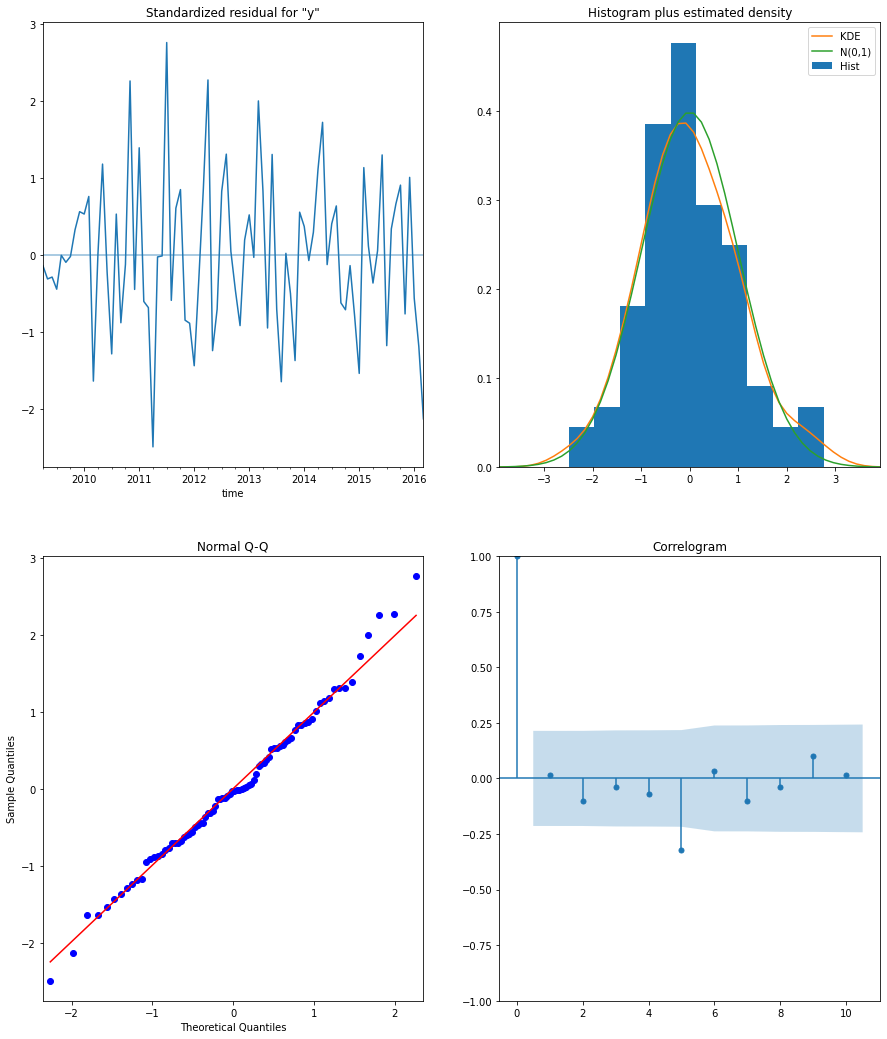

In [66]:
output.plot_diagnostics(figsize=(15,18))
plt.show()

The model's prediction against the testing data is still pretty disappointing. It didn't even get the direction of the trend correct. 

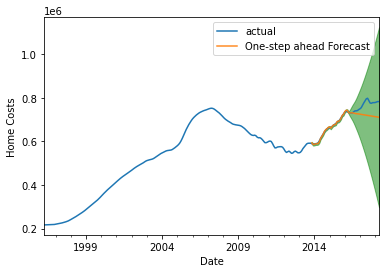

In [68]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-11-01'), end= pd.to_datetime('2018-04-01'), dynamic=False)
pred_conf = pred.conf_int()

ax = isolate_zip(df, 60640).plot(label='actual')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Costs')
plt.legend()

plt.show()

I switched to the city-wide data to see if the aggregation would smooth out the noise. 

In [69]:
arima_model = ARIMA(city_train, order=(1, 1, 1)).fit()
arima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  201
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1794.512
Date:                Tue, 18 May 2021   AIC                           3595.024
Time:                        12:21:00   BIC                           3604.919
Sample:                    04-01-1996   HQIC                          3599.029
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9814      0.005    188.844      0.000       0.971       0.992
ma.L1         -0.9662      0.007   -144.523      0.000      -0.979      -0.953
sigma2      3.486e+06   1.24e-10   2.81e+16      0.000    3.49e+06    3.49e+06
===================================================================================
Ljung-Box (L1) (Q):                 186.30   Jarque-Bera (JB):                18.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.20   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.98e+31. Standard errors may be unstable.
"""

In [70]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

ans = []
for comb in pdq:
    try:
        mod = ARIMA(city_train,
                    order=comb,
                    enforce_stationarity=False,
                    enforce_invertibility=False)

        output = mod.fit()
        ans.append([comb, output.aic])
        print('ARIMA {} : AIC Calculated ={}'.format(comb, output.aic))
    except ValueError:
        pass

ARIMA (0, 0, 0) : AIC Calculated =5949.050483191719
ARIMA (0, 0, 1) : AIC Calculated =4915.281288165388
ARIMA (0, 0, 2) : AIC Calculated =4850.597955264955
ARIMA (0, 1, 0) : AIC Calculated =3652.69560212541
ARIMA (0, 1, 1) : AIC Calculated =3381.942658483885
ARIMA (0, 1, 2) : AIC Calculated =3162.4906799514893
ARIMA (0, 2, 0) : AIC Calculated =3035.058789675667
ARIMA (0, 2, 1) : AIC Calculated =2991.5442875199296
ARIMA (0, 2, 2) : AIC Calculated =2967.8521033523407
ARIMA (1, 0, 0) : AIC Calculated =3660.753693650725
ARIMA (1, 0, 1) : AIC Calculated =3492.233451466652
ARIMA (1, 0, 2) : AIC Calculated =3171.506628231263
ARIMA (1, 1, 0) : AIC Calculated =3049.1153737103477
ARIMA (1, 1, 1) : AIC Calculated =3014.55101256158
ARIMA (1, 1, 2) : AIC Calculated =2980.6196077214404
ARIMA (1, 2, 0) : AIC Calculated =3021.713777084651
ARIMA (1, 2, 1) : AIC Calculated =2980.9972506581826
ARIMA (1, 2, 2) : AIC Calculated =2967.365457786339
ARIMA (2, 0, 0) : AIC Calculated =3048.3221655682187
ARIMA (

With p-values that high, this model was a non-starter, but I went ahead and plotted the diagnostics out of curiosity. 

In [71]:
output = ARIMA(city_train, order=(2, 2, 2),
              enforce_stationarity=False,
              enforce_invertibility=False).fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  201
Model:                 ARIMA(2, 2, 2)   Log Likelihood               -1479.049
Date:                Tue, 18 May 2021   AIC                           2968.097
Time:                        12:21:06   BIC                           2984.488
Sample:                    04-01-1996   HQIC                          2974.733
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1937      0.387      0.500      0.617      -0.566       0.953
ar.L2          0.0851      0.137      0.623      0.534      -0.183       0.353
ma.L1          0.2183      0.393      0.555      0.579      -0.553       0.989
ma.L2         -0.3627      0.298     -1.219      0.223      -0.946       0.221
sigma2       2.05e+05   1.16e+04     17.728      0.000    1.82e+05    2.28e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               282.32
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):              22.87   Skew:                             0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

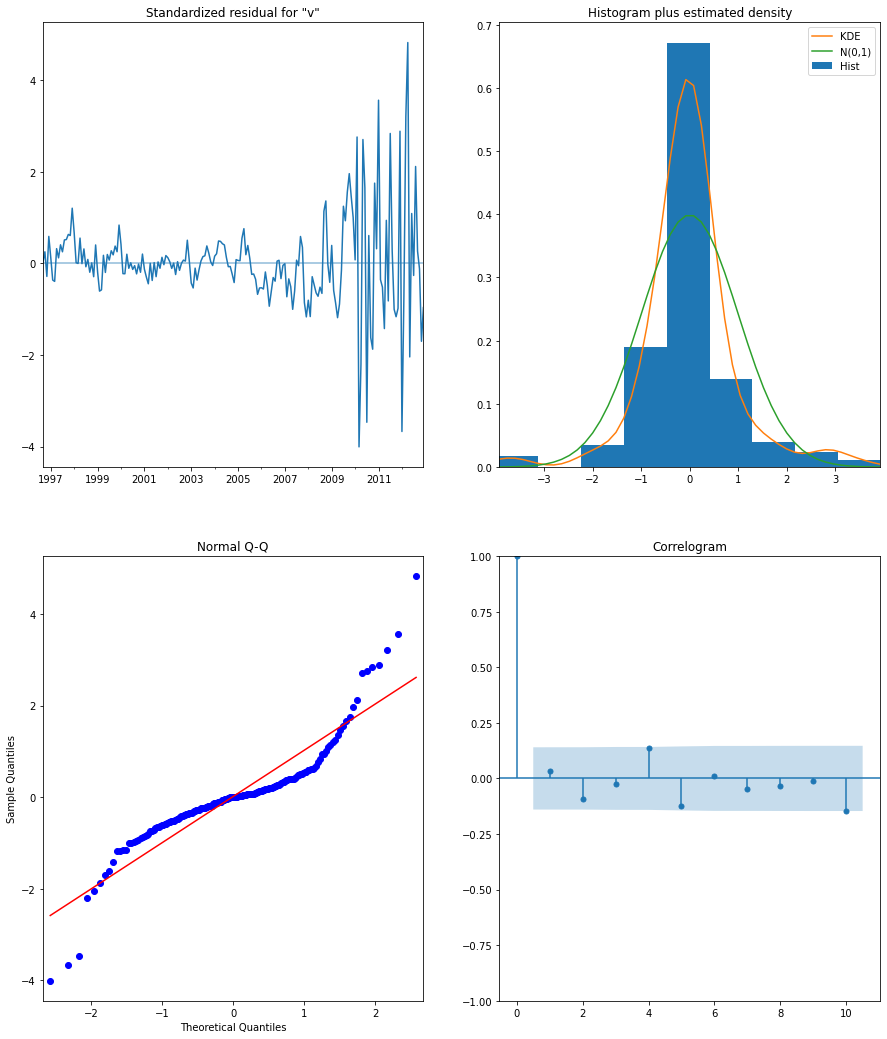

In [72]:
output.plot_diagnostics(figsize=(15,18))
plt.show()

I was also curious if the direction of the prediction was influenced by the noise at the specific month that I did my test-train split. I fiddled with the date of the test-train split some, and found that that was probably the case. At this point, it looked like noise was my biggest issue. I switched to a SARIMAX model to try to mitigate the effect of any subtle seasonality patterns.

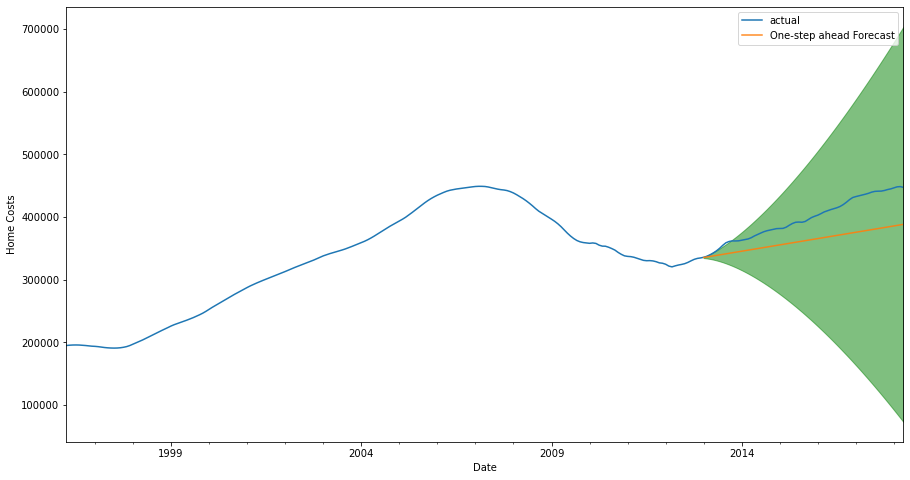

In [73]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-01-01'), end= pd.to_datetime('2018-04-01'), dynamic=False)
pred_conf = pred.conf_int()

plt.figure(figsize=(15, 8))
ax = city_model.plot(label='actual')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Costs')
plt.legend()

plt.show()

### SARIMAX

I ran my original aggregated data using SARIMAX instead of ARIMA in order to mitigate the influence of any underlying patterns.

In [77]:
SARIMAX_model = SARIMAX(city_train, 
                        order=(1, 1, 1), 
                        seasonal_order=(1, 1, 1, 12), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
output = SARIMAX_model.fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  201
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1355.216
Date:                            Tue, 18 May 2021   AIC                           2720.432
Time:                                    12:27:26   BIC                           2736.228
Sample:                                04-01-1996   HQIC                          2726.840
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9549      0.026     37.337      0.000       0.905       1.005
ma.L1          0.1908      0.031      6.127      0.000       0.130       0.252
ar.S.L12       0.1545      0.014     10.954      0.000       0.127       0.182
ma.S.L12      -0.8841      0.047    -18.682      0.000      -0.977      -0.791
sigma2      2.623e+05   1.98e+04     13.241      0.000    2.23e+05    3.01e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.65   Jarque-Bera (JB):               291.62
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):              12.04   Skew:                             0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []

for comb in pdq:
    for combs in pdqs:
        try:
            mod = SARIMAX(city_train,
                        order=comb,
                        seasonal_order=combs,
                        enforce_stationarity=False,
                        enforce_invertibility=False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
        except ValueError:
            pass

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =5663.069874453386
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =462575.81527103344
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =4372.935574003126
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =4106.497136777232
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =4389.07767470336
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =4351.222433874235
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =3929.5931254343145
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =5295.90203456133
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =5491.945234065466
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =473301.14689530636
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =4388.423342226522
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =5939.153154065834
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =5529.376675899184
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =5116.334964635006
ARIMA (0, 0, 1) x (

The results were fairly similar to the ARIMA plot.

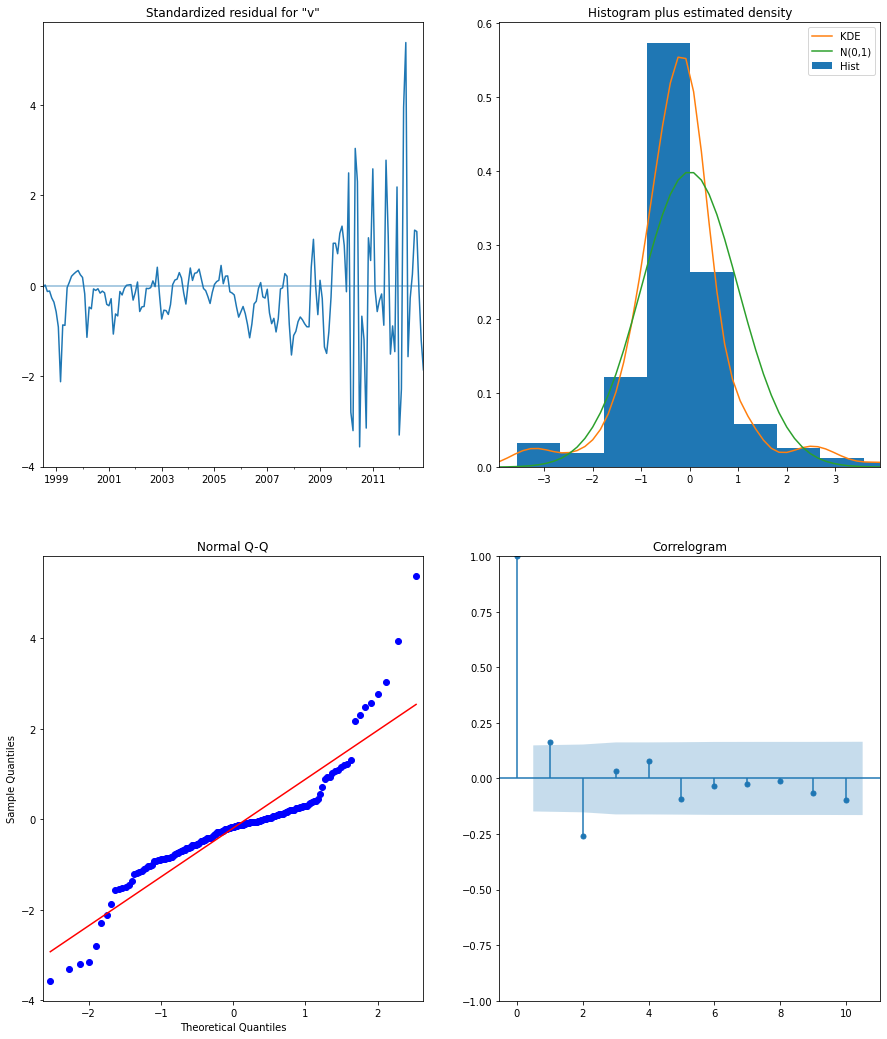

In [79]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

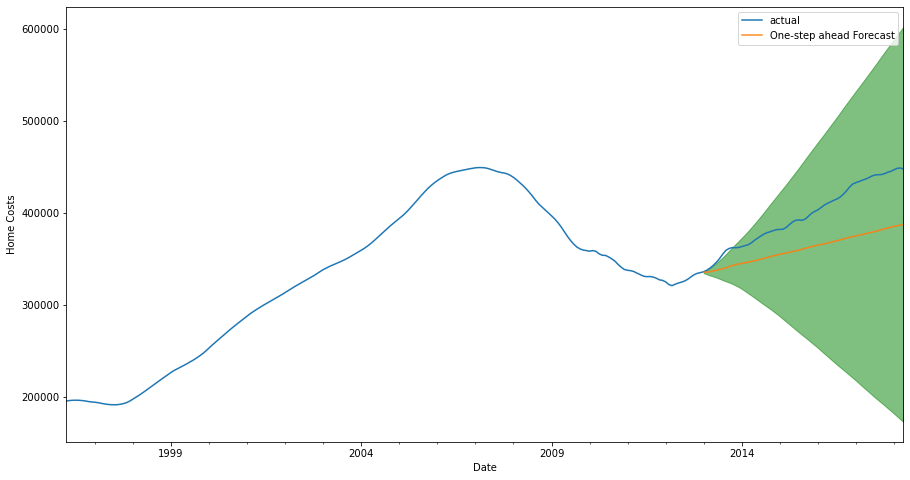

In [80]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-01-01'), end= pd.to_datetime('2018-04-01'), dynamic=False)
pred_conf = pred.conf_int()

plt.figure(figsize=(15, 8))
ax = city_model.plot(label='actual')

pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Costs')
plt.legend()

plt.show()

Since I suspected that underlying patterns were influencing the model, I decided to decompose the data and try using only the trend to train the model. 

In [81]:
SARIMAX_model = SARIMAX(trend[:'2013-11'], 
                        order=(1, 1, 1), 
                        seasonal_order=(1, 1, 1, 12), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
output = SARIMAX_model.fit()
output.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              trend   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1199.039
Date:                            Tue, 18 May 2021   AIC                           2408.077
Time:                                    12:29:44   BIC                           2424.179
Sample:                                04-01-1996   HQIC                          2414.603
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9723      0.014     67.854      0.000       0.944       1.000
ma.L1          0.5821      0.073      8.027      0.000       0.440       0.724
ar.S.L12      -0.0083      0.004     -2.219      0.026      -0.016      -0.001
ma.S.L12       2.5078      0.274      9.146      0.000       1.970       3.045
sigma2      3478.9314   1072.501      3.244      0.001    1376.868    5580.995
===================================================================================
Ljung-Box (L1) (Q):                 108.48   Jarque-Bera (JB):                 2.64
Prob(Q):                              0.00   Prob(JB):                         0.27
Heteroskedasticity (H):               2.03   Skew:                            -0.15
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

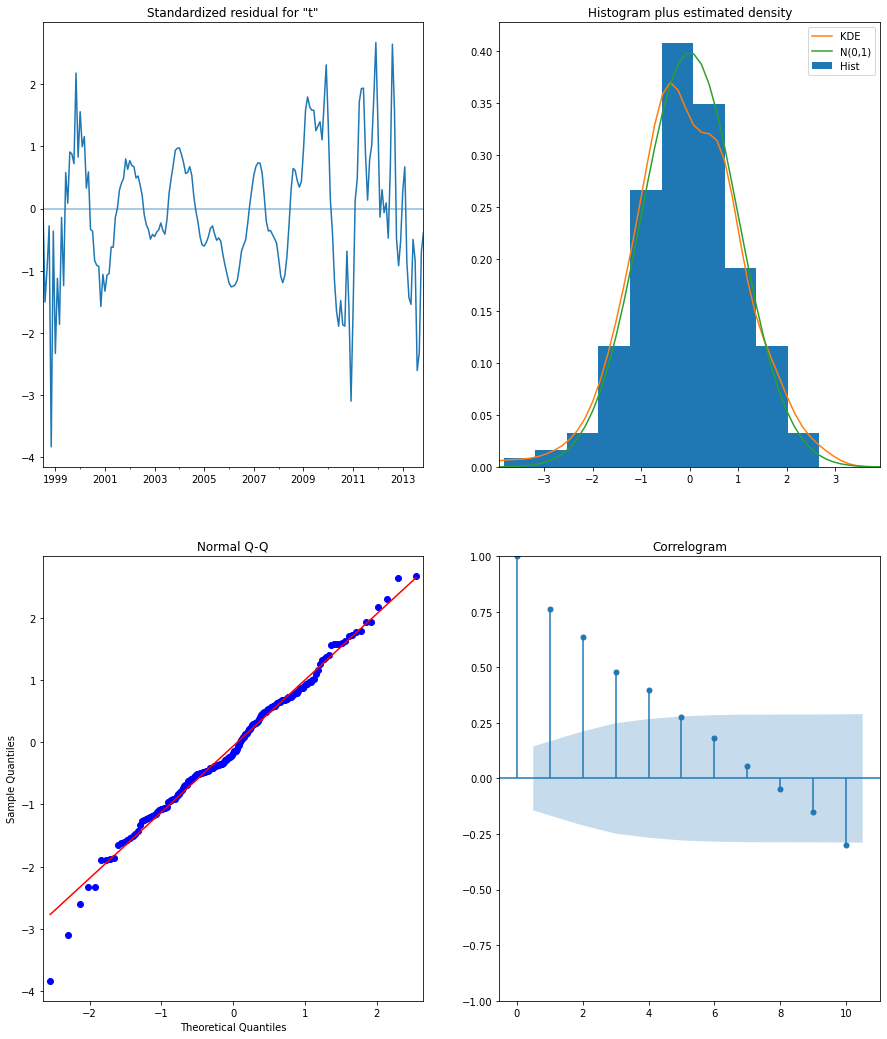

In [82]:
# Call plot_diagnostics() on the results calculated above 
output.plot_diagnostics(figsize=(15, 18))
plt.show()

This helped both the diagnostics and the prediction immensely. To confirm that the model was not simply replicating the pattern at the point of the test-train split, I went ahead and moved it back to the original calculated cutoff.

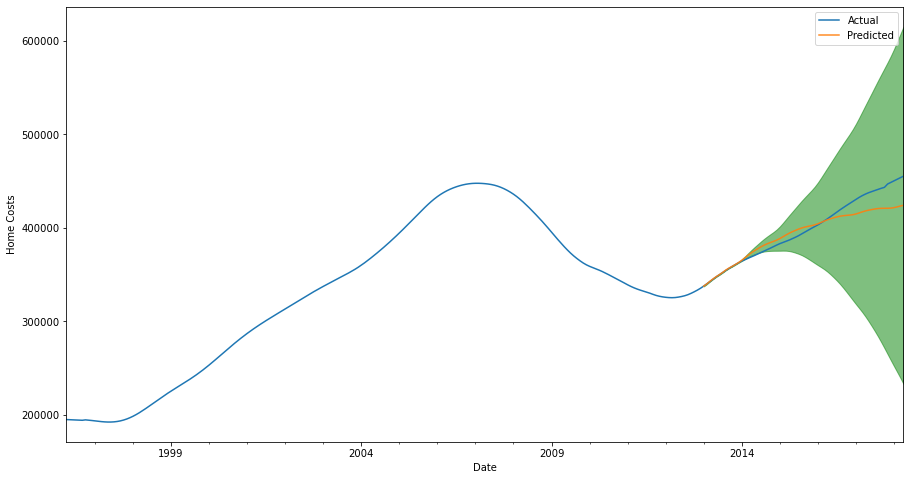

In [83]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output.get_prediction(start=pd.to_datetime('2013-01-01'), end= pd.to_datetime('2018-04-01'), dynamic=False)
pred_conf = pred.conf_int()

plt.figure(figsize=(15, 8))
ax = trend.plot(label='Actual')

pred.predicted_mean.plot(ax=ax, label='Predicted', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Costs')
plt.legend()

plt.show()

Not seeing a change from that shift improved my confidence in this model immensely. I also turned on the 'dynamic' parameter to allow the model to predict against itself, which brought it a bit closer to the test data. 

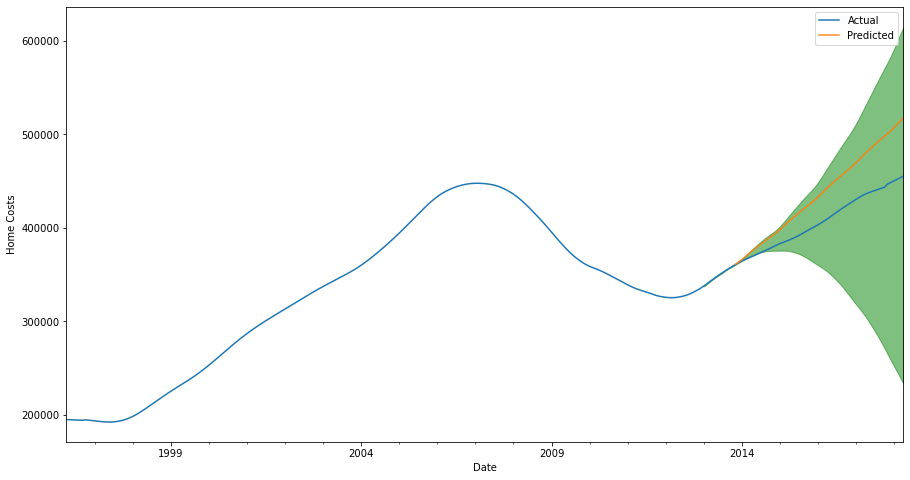

In [92]:
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred_dynamic = output.get_prediction(start=pd.to_datetime('2013-11-01'), end= pd.to_datetime('2018-04-01'), dynamic=True, full_results = True)
pred_dynamic_conf = pred.conf_int()

plt.figure(figsize=(15, 8))
ax = trend.plot(label='Actual')

pred_dynamic.predicted_mean.plot(ax=ax, label='Predicted', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_dynamic_conf.index,
                pred_dynamic_conf.iloc[:, 0],
                pred_dynamic_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Home Costs')
plt.legend()

plt.show()

The MSE of the final model was much improved as well. 

In [94]:
# Get the real and predicted values
forecasted = pred.predicted_mean
actual = trend

# Compute the mean square error
mse = ((forecasted - actual) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 156209160.54


Finally, I used my model to make a forecast beyond the given data.

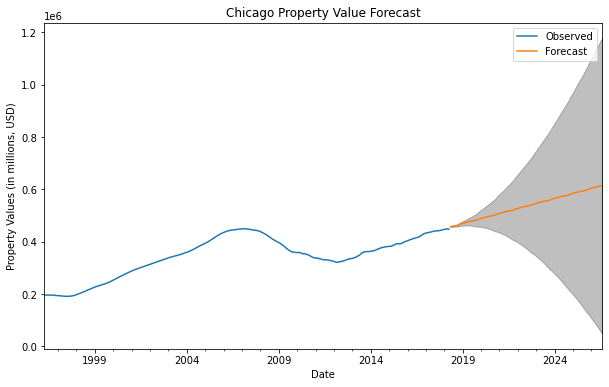

In [89]:
SARIMAX_model = SARIMAX(trend, 
                        order=(1, 1, 1), 
                        seasonal_order=(1, 1, 1, 12), 
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
output = SARIMAX_model.fit()

# Get forecast 500 steps ahead in future
prediction = output.get_forecast(steps=100)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = city_model.plot(label='Observed', figsize=(10, 6))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='k', alpha=0.25)
ax.set_xlabel('Date')
ax.set_ylabel('Property Values (in millions, USD)')
ax.set_title('Chicago Property Value Forecast')

plt.legend()
plt.show()

And calculated the slope (by hand) of the forecast.

In [90]:
((prediction.predicted_mean[99])-(prediction.predicted_mean[0]) ) // (100//12)

19649.0

### Evaluating

Overall, I had strong confidence in my model, given the low p-values in all but the first MA lag, and the low AIC and MSE. The 

## Conclusions

### Recommendations

Understanding that the forecast for Chicago home values overall indicates that the TIF funding across all districts is fairly secure. Not only can we expect to have a secure amount of funding for current future projects, we know that those funds are likely going to increase over time. 

With this information, we can speculate with some security on future TIF income. Allowing projects to proceed on bonds that will be reimbursed in the future might be a viable strategy, particularly for products in areas of the city where the increase in home values is lagging. 